# Random Forests in trading 

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import re

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

## import model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Definitions for indicators

In [2]:
# 1. Gain, Loss, Average Gain, and Average Loss Calculation
# These are needed for the RSI calculation but can also be calculated separately if you want to track them.

# 2. SMA (Simple Moving Average)
# The SMA is a straightforward calculation of the average closing prices over a specified window.

# 3. EMA (Exponential Moving Average)
# The EMA gives more weight to recent prices.

# 4. Rate of Change (ROC)
# The ROC shows the percentage change between the current price and the price n periods ago.

# 5. Price Volume Trend (PVT)
# The PVT is a cumulative indicator that combines price and volume to calculate market trends.

# Gain, Loss, Avg_Gain, and Avg_Loss
def gain_loss(df):
    df['Change'] = df['Close'].diff()
    df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)
    df['Loss'] = df['Change'].apply(lambda x: -x if x < 0 else 0)
    df['Avg_Gain'] = df['Gain'].rolling(window=14).mean()
    df['Avg_Loss'] = df['Loss'].rolling(window=14).mean()
    return df

# Simple Moving Average (SMA)
def SMA(df, window=20):
    df['SMA'] = df['Close'].rolling(window=window).mean()
    return df

# Exponential Moving Average (EMA)
def EMA(df, window=20):
    df['EMA'] = df['Close'].ewm(span=window, adjust=False).mean()
    return df

# Relative Strength Index (RSI)
def RSI(df):
    df['change_in_price'] = df['Close'].diff()
    up_df, down_df = df[['change_in_price']].copy(), df[['change_in_price']].copy()
    up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
    down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0
    down_df['change_in_price'] = down_df['change_in_price'].abs()
    ewma_up = up_df['change_in_price'].ewm(span=14).mean()
    ewma_down = down_df['change_in_price'].ewm(span=14).mean()
    relative_strength = ewma_up / ewma_down
    df['RSI'] = 100.0 - (100.0 / (1.0 + relative_strength))
    return df

# Stochastic Oscillator
def SO(df):
    low_14 = df['Low'].rolling(window=14).min()
    high_14 = df['High'].rolling(window=14).max()
    df['k_percent'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
    return df

# Williams %R
def r_percent(df):
    low_14 = df['Low'].rolling(window=14).min()
    high_14 = df['High'].rolling(window=14).max()
    df['r_percent'] = -100 * ((high_14 - df['Close']) / (high_14 - low_14))
    return df

# Moving Average Convergence Divergence (MACD)
def MACD(df):
    ema_26 = df['Close'].ewm(span=26).mean()
    ema_12 = df['Close'].ewm(span=12).mean()
    macd = ema_12 - ema_26
    df['MACD'] = macd
    df['MACD_EMA'] = macd.ewm(span=9).mean()
    return df

# Price Rate of Change (PROC)
def ROC(df, n=12):
    df['ROC'] = df['Close'].pct_change(periods=n) * 100
    return df

# Price Volume Trend (PVT)
def PVT(df):
    df['PVT'] = (df['Close'].pct_change() * df['Volume']).cumsum()
    return df

# Bollinger Bands
def Bollinger_Bands(df, window=20):
    sma = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()
    df['Bollinger_Upper'] = sma + (rolling_std * 2)
    df['Bollinger_Lower'] = sma - (rolling_std * 2)
    return df

## Import data from yfinance

#### Motivation of the data

- Ford, the second-largest automaker in the US, has a number of suppliers, including many famous indirect suppliers.
- Major suppliers of airbags include Autoliv, while Warn Industries supplies axle assemblies and Flex-N-Gate Seeburn supplies door hinges and arms. 
- Indirect suppliers include FedEx, Union Pacific, and Roush. 

Toyota has many suppliers, including: 
- Denso: A major supplier of automotive parts and chips, and a leading supplier to Toyota. Denso receives about half of its revenue from Toyota. 
- Aisin Seiki Co. A supplier of automobile components and systems. 
- Microchip Technology: A supplier of infotainment systems for Toyota and other manufacturers. 
- Johnson Controls: A supplier of seats and interior parts. 
- Takata Corporation: A supplier of seatbelts, airbags, and child restraint systems. 
- Dunlop Goodyear Tires, Ltd. A supplier of tires. 
- TRW Automotive Japan Co., Ltd. A supplier of steering systems and suspension parts. 
- TPR Co., Ltd. A supplier of piston rings and cylinder liners. 
- T. RAD Co., Ltd. A supplier of radiators, oil coolers, and intercoolers. 
- Topre Corporation: A supplier of reinforced bumpers and center pillars. 
- Toyo Quality One Corporation: A supplier of molded urethane foam (seat pads). 
- Topy Industries, Limited: A supplier of automotive disc wheels. 

In [3]:
import yfinance as yf
import pandas as pd

# Define the companies and their tickers, including currency pairs and indices
tickers = [
    'F', 'ALV', 'FDX', 'DNZOY', 'ASEKY', 'JCI', 'GM', 'TM', 'CL=F', 'X', 'ALI=F',  # Company tickers
    'EURUSD=X', 'CHFUSD=X', 'GBPUSD=X', 'JPYUSD=X', 'CADUSD=X', 'INRUSD=X', 'RUBUSD=X', 'TRYUSD=X',  # Currencies
    '^IRX', 'JPM', 'BAC', 'C', 'WFC',  # Financial companies and IRX
    '^IXIC', '^GSPC', '^DJI'  # NASDAQ, S&P 500, Dow Jones
]

# Download the data for the defined tickers (5 years of data)
data = yf.download(tickers, period="5y")

# Display the first few rows of the Close prices data
print(data['Close'].head())

# Optionally, save the Close prices to a CSV file for further analysis
data['Close'].to_csv('financial_data_with_currencies_indices.csv')


[*********************100%***********************]  27 of 27 completed


Ticker                       ALI=F        ALV      ASEKY        BAC  \
Date                                                                  
2019-11-14 00:00:00+00:00  1750.50  82.800003  13.180000  32.700001   
2019-11-15 00:00:00+00:00  1754.00  83.339996  13.180000  32.930000   
2019-11-18 00:00:00+00:00  1752.00  82.220001  13.180000  32.959999   
2019-11-19 00:00:00+00:00  1745.75  80.150002  12.566667  32.939999   
2019-11-20 00:00:00+00:00  1758.50  78.529999  12.566667  32.689999   

Ticker                             C  CADUSD=X  CHFUSD=X       CL=F   DNZOY  \
Date                                                                          
2019-11-14 00:00:00+00:00  73.839996  0.754609  1.010438  56.770000  11.335   
2019-11-15 00:00:00+00:00  74.400002  0.754728  1.011358  57.720001  11.510   
2019-11-18 00:00:00+00:00  74.400002  0.756292  1.011137  57.049999  11.450   
2019-11-19 00:00:00+00:00  74.820000  0.757186  1.011020  55.209999  11.505   
2019-11-20 00:00:00+00:00  7

I want to plot a correlation chart with only close price data of each company for understanding their dependencies.

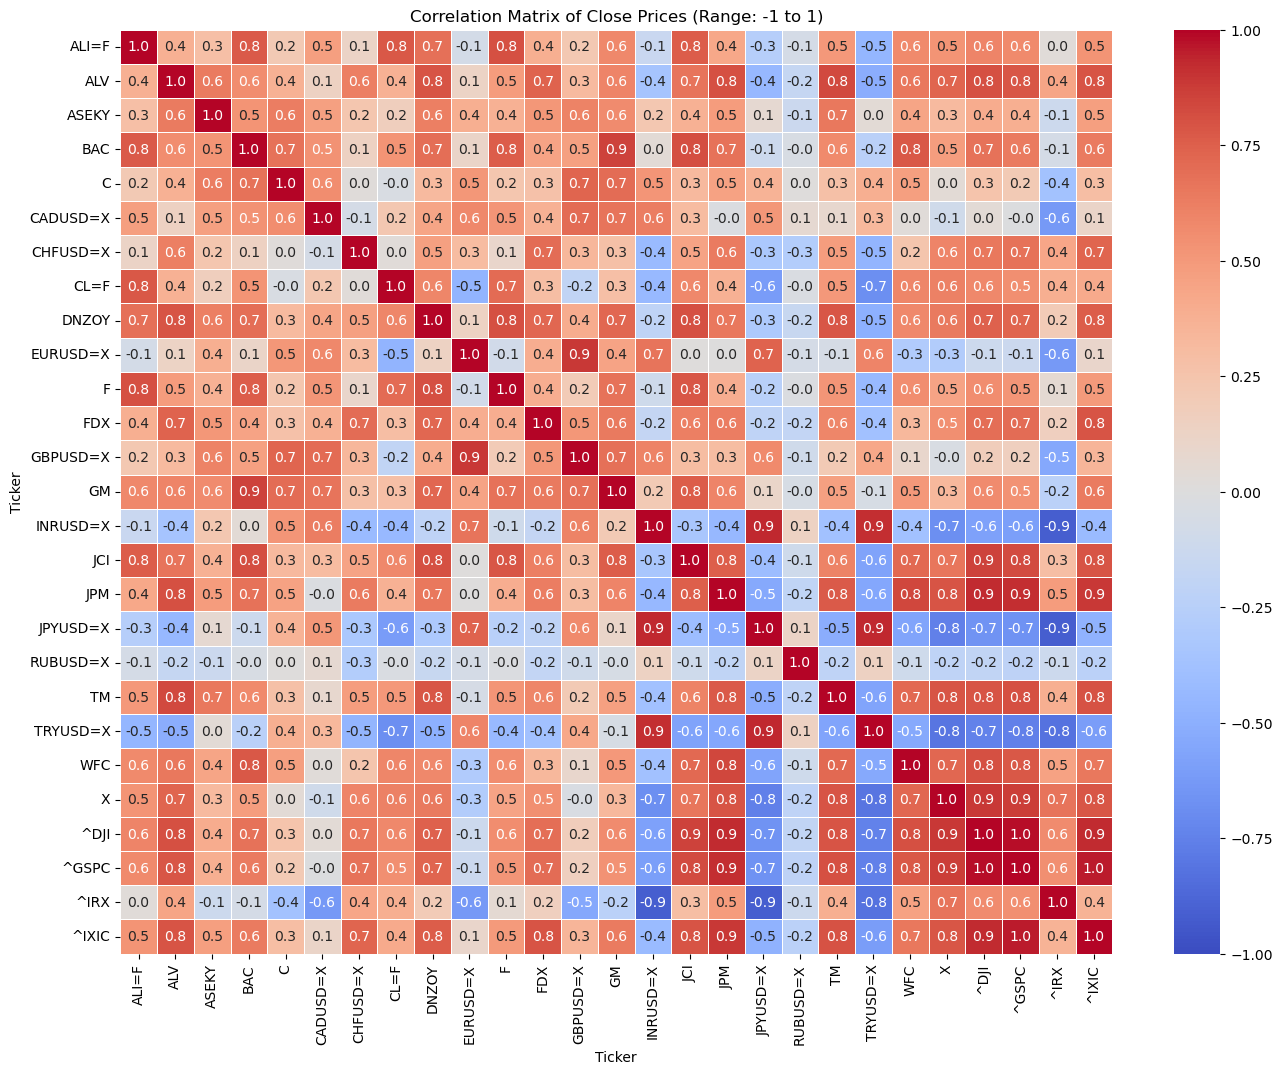

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the Close price data
close_prices = data['Close']

# Compute the correlation matrix of the Close prices
correlation_matrix = close_prices.corr()

# Enlarge the figure and format annotations to 1 decimal place
plt.figure(figsize=(16, 12))  # Enlarge the figure
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1, fmt='.1f')  # Format annotations
plt.title('Correlation Matrix of Close Prices (Range: -1 to 1)')
plt.show()


Now observe that Denso has strong correlation with the most of the other companies. So we can predict Denso stock market data with the help of other companies.

In [5]:
data = data.dropna()

In [6]:
data.to_csv('data.csv', index=True)

In [7]:
# Assuming 'correlation_matrix' has already been calculated as in the previous code

# Extract the correlations of Denso (ticker 'DNZOY') with other features
ford_correlations = correlation_matrix['F']

# Select features where the absolute correlation is greater than 0.4
selected_features = ford_correlations[abs(ford_correlations) > 0.4]

# Drop Denso itself from the list (as its correlation with itself is 1)
selected_features = selected_features

# Display the selected features and their correlations
print("Features with absolute correlation greater than 0.4 with Denso:")
print(selected_features)


Features with absolute correlation greater than 0.4 with Denso:
Ticker
ALI=F       0.808553
ALV         0.486769
BAC         0.764612
CADUSD=X    0.516640
CL=F        0.707159
DNZOY       0.807396
F           1.000000
GM          0.674926
JCI         0.784721
TM          0.517919
TRYUSD=X   -0.436232
WFC         0.557928
X           0.451840
^DJI        0.559028
^GSPC       0.523090
^IXIC       0.495219
Name: F, dtype: float64


### Granger Causality:
I used granger causality here, which has shown 'CADUSD=X', 'GM', 'JCI', 'TM', 'TRYUSD=X', '^IXIC' and 'F'.

In [8]:
selected_features_g = ['CADUSD=X', 'GM', 'JCI', 'TM', 'TRYUSD=X', '^IXIC','F']

In [9]:
import yfinance as yf
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Step 1: Import data
ticker = 'F'
ford_data = yf.download(ticker, start="2010-01-01", end="2023-01-01")

# Step 2: Preprocess data
# Let's assume you are using some daily metrics like Open, High, Low, Close, Volume for VIF calculations
# Drop rows with any missing values
ford_data.dropna(inplace=True)

# Step 3: Prepare the predictors
# Selecting some columns as predictors
predictors = ford_data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Add a constant for intercept
predictors = add_constant(predictors)

# Step 4: Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Variable"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

# Step 5: Display VIF results
print(vif_data)

[*********************100%***********************]  1 of 1 completed

  Variable          VIF
0    const    22.343840
1     Open   860.849730
2     High  1379.452628
3      Low  1021.143742
4    Close   940.590302
5   Volume     2.035584


In [10]:
# Assuming your technical indicator functions (EMA, SMA, etc.) are already defined
# Calculate technical indicators for each feature
def calculate_indicators(df, ticker):
    df = gain_loss(df)
    df = SMA(df)
    df = EMA(df)
    df = RSI(df)
    df = SO(df)
    df = r_percent(df)
    df = MACD(df)
    df = ROC(df)
    df = PVT(df)
    df = Bollinger_Bands(df)
    
    # Rename columns to reflect the ticker (e.g., F_EMA, ALV_SMA)
    df = df.rename(columns=lambda col: f"{ticker}_{col}")
    
    return df

In [11]:
# Function to create the dataset using selected features and Denso's closing price
def create_dataset_1(data, selected_features_g, target_ticker='F'):
    df_features = pd.DataFrame()
    
    # Add the indicators and volume for each selected feature
    for ticker in selected_features_g:
        try:
            # Extract the individual ticker data (Close, High, Low, Volume)
            ticker_data = pd.DataFrame({
                'Open': data['Open'][ticker],
                'Close': data['Close'][ticker],
                'High': data['High'][ticker],
                'Low': data['Low'][ticker],
                'Volume': data['Volume'][ticker]
            })
        except KeyError:
            print(f"Ticker '{ticker}' not found in data. Skipping.")
            continue
        
        # Calculate indicators and add to the dataset
        indicator_data = calculate_indicators(ticker_data.copy(), ticker)
        
        # Merge the calculated indicators into the final feature dataset
        df_features = pd.concat([df_features, indicator_data], axis=1)
    
    # Add Denso's closing price as the predictor variable
    df_features[f'{target_ticker}_Close'] = data['Close'][target_ticker]
    
    # # Apply the prediction_class function on Denso's Close price
    # df_features = prediction_class(df_features)
    
    return df_features

In [12]:
# Create the first dataset (selected features with technical indicators and Denso's price)
dataset_reg = create_dataset_1(data, selected_features_g)
dataset_others = create_dataset_1(data, selected_features_g)

In [13]:
data['Close']["F"]

Date
2019-11-14 00:00:00+00:00     8.79
2019-11-15 00:00:00+00:00     8.95
2019-11-18 00:00:00+00:00     8.95
2019-11-19 00:00:00+00:00     8.90
2019-11-20 00:00:00+00:00     8.73
                             ...  
2024-11-07 00:00:00+00:00    10.96
2024-11-08 00:00:00+00:00    10.97
2024-11-11 00:00:00+00:00    11.23
2024-11-12 00:00:00+00:00    11.10
2024-11-13 00:00:00+00:00    11.10
Name: F, Length: 1258, dtype: float64

In [14]:
dataset_reg = dataset_reg.rename(columns={'F_Close': 'F_Close_pred'})
dataset_others = dataset_others.rename(columns={'F_Close': 'F_Close_pred'})

In [15]:
dataset_reg = dataset_reg.dropna()
# Drop rows with missing values and remove specific columns
dataset_reg = dataset_reg.dropna().drop(columns=['F_High', 'F_Low', 'F_Open'])

In [16]:
# Check the number of missing values in each column
missing_counts = dataset_others.isna().sum()
print(missing_counts[missing_counts > 0])  # Only display columns with missing values

CADUSD=X_Change              1
CADUSD=X_Avg_Gain           13
CADUSD=X_Avg_Loss           13
CADUSD=X_SMA                19
CADUSD=X_change_in_price     1
                            ..
F_r_percent                 13
F_ROC                       12
F_PVT                        1
F_Bollinger_Upper           19
F_Bollinger_Lower           19
Length: 84, dtype: int64


In [17]:
dataset_others = dataset_others.dropna()

In [18]:
# Save the dataset to a CSV file
dataset_reg.to_csv('dataset_reg.csv', index=True)
dataset_others.to_csv('dataset_others.csv', index=True)

## For classification

In [19]:
dataset_log_reg = dataset_reg.copy()
dataset_log_reg["F_Close_pred_class"]= np.where(dataset_log_reg['F_Close_pred'] < dataset_log_reg['F_Close_pred'].shift(-1), 1, 0)

# Drop the 'DNZOY_Close_pred' column
dataset_log_reg = dataset_log_reg.drop(columns=['F_Close_pred'])

# Drop any rows with missing values (NaN)
dataset_log_reg = dataset_log_reg.dropna()

In [20]:
dataset_others_class = dataset_others.copy()
dataset_others_class["F_Close_pred_class"]= np.where(dataset_others_class['F_Close_pred'] < dataset_others_class['F_Close_pred'].shift(-1), 1, 0)

# Drop the 'DNZOY_Close_pred' column
dataset_others_class = dataset_others_class.drop(columns=['F_Close_pred'])

# Drop any rows with missing values (NaN)
dataset_others_class = dataset_others_class.dropna()

In [21]:
# Save the dataset to a CSV file
dataset_log_reg.to_csv('dataset_log_reg.csv', index=True)
dataset_others_class.to_csv('dataset_others_class.csv', index=True)

In [22]:
xf_col = pd.DataFrame(dataset_others_class.columns)
xr_col = pd.DataFrame(dataset_reg.columns)

In [23]:
dataset_others.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1239 entries, 2019-12-12 00:00:00+00:00 to 2024-11-13 00:00:00+00:00
Columns: 154 entries, CADUSD=X_Open to F_Bollinger_Lower
dtypes: float64(152), int64(2)
memory usage: 1.5 MB
